In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import re
from collections import Counter
import datetime as dt
import io

warnings.filterwarnings('ignore')

# Set the aesthetic style of the plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# 1. Load and Explore the Data
print("Loading and exploring the dataset...")

# Create a function to handle the CSV parsing issues
def parse_csv_data(csv_text):
    # Convert the raw CSV text to a DataFrame
    # Split by lines
    lines = csv_text.strip().split('\n')
    
    # Get headers from first line
    headers = lines[0].split(',')
    
    # Process each row
    processed_rows = []
    for line in lines[1:]:
        # Replace the special quote markers before splitting
        line = line.replace('+ACI-', '"').replace('+ACI', '"').replace('+AC0-', '-')
        
        # Split by commas, but respect quotation marks
        values = []
        current_value = ""
        in_quotes = False
        
        for char in line:
            if char == '"' and not in_quotes:
                in_quotes = True
                current_value += char
            elif char == '"' and in_quotes:
                in_quotes = False
                current_value += char
            elif char == ',' and not in_quotes:
                values.append(current_value)
                current_value = ""
            else:
                current_value += char
        
        # Add the last value
        values.append(current_value)
        
        processed_rows.append(values)
    
    # Create DataFrame
    return pd.DataFrame(processed_rows, columns=headers)

# Sample data from the description
# csv_text = """TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),OwnedProducts
# T1,C5841053,1994+AC0-01+AC0-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25,+ACI-credit card, loans, savings+ACI-
# T2,C2142763,2057+AC0-04+AC0-04,M,JHAJJAR,2270.69,2/8/16,141858,27999,tds
# T3,C4417068,1996+AC0-11+AC0-26,F,MUMBAI,17874.44,2/8/16,142712,459,+ACI-loans, savings+ACI-
# T4,C5342380,2073+AC0-09+AC0-14,F,MUMBAI,866503.21,2/8/16,142714,2060,+ACI-long term investment, savings+ACI-
# T5,C9031234,1988+AC0-03+AC0-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5,+ACI-loans, savings+ACI-
# T6,C1536588,2072+AC0-10+AC0-08,F,ITANAGAR,53609.2,2/8/16,173940,676,savings
# T7,C7126560,1992+AC0-01+AC0-26,F,MUMBAI,973.46,2/8/16,173806,566,+ACI-loans, retirement plan+ACI-
# T8,C1220223,1982+AC0-01+AC0-27,M,MUMBAI,95075.54,2/8/16,170537,148,+ACI-cds, credit card, retirement plan, savings+ACI-
# T9,C8536061,1988+AC0-04+AC0-19,F,GURGAON,14906.96,2/8/16,192825,833,+ACI-credit card, loans, savings+ACI-
# T10,C6638934,1984+AC0-06+AC0-22,M,MUMBAI,4279.22,2/8/16,192446,289.11,loans
# T11,C5430833,1982+AC0-07+AC0-22,M,MOHALI,48429.49,2/8/16,204133,259,+ACI-credit card, savings+ACI-
# T12,C6939838,1988+AC0-07+AC0-07,M,GUNTUR,14613.46,2/8/16,205108,202,+ACI-credit card, loans, savings+ACI-
# T13,C6339347,1978+AC0-06+AC0-13,M,AHMEDABAD,32274.78,2/8/16,203834,12300,+ACI-credit card, savings+ACI-
# T14,C8327851,1992+AC0-01+AC0-05,F,THANE,59950.44,1/8/16,84706,50,+ACI-cds, credit card, savings+ACI-
# T15,C7917151,1978+AC0-03+AC0-24,M,PUNE,10100.84,1/8/16,82253,338,+ACI-credit card, loans, savings+ACI-
# T16,C8334633,2068+AC0-07+AC0-10,F,NEW DELHI,1283.12,1/8/16,125725,250,
# T17,C1376215,1800+AC0-01+AC0-01,M,MUMBAI,77495.15,1/8/16,124727,1423.11,+ACI-cds, credit card, retirement plan, savings+ACI-
# T18,C8967349,1989+AC0-07+AC0-16,M,MUMBAI,2177.85,1/8/16,124734,54,loans
# T19,C3732016,1991+AC0-01+AC0-11,M,MUMBAI,32816.17,1/8/16,122135,315,+ACI-credit card, savings+ACI-"""


# Step 1: Read the file content as plain text
with open('bank_customer_transactions.csv', 'r', encoding='utf-8') as f:
    csv_text = f.read()

# Step 2: Pass it to your custom parsing function
df = parse_csv_data(csv_text)


Loading and exploring the dataset...


In [2]:
# Display the first few rows
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053  1994-01-10          F   JAMSHEDPUR   
1            T2   C2142763  2057-04-04          M      JHAJJAR   
2            T3   C4417068  1996-11-26          F       MUMBAI   
3            T4   C5342380  2073-09-14          F       MUMBAI   
4            T5   C9031234  1988-03-24          F  NAVI MUMBAI   

  CustAccountBalance TransactionDate TransactionTime TransactionAmount (INR)  \
0           17819.05          2/8/16          143207                      25   
1            2270.69          2/8/16          141858                   27999   
2           17874.44          2/8/16          142712                     459   
3          866503.21          2/8/16          142714                    2060   
4            6714.43          2/8/16          181156                  1762.5   

                     OwnedProducts  
0    "credit card, loans, savings"  
1                

In [3]:
# Check data types
print("\nData types:")
print(df.dtypes)


Data types:
TransactionID              object
CustomerID                 object
CustomerDOB                object
CustGender                 object
CustLocation               object
CustAccountBalance         object
TransactionDate            object
TransactionTime            object
TransactionAmount (INR)    object
OwnedProducts              object
dtype: object


In [4]:
'''
TransactionTime: int
143207 → 14:32:07 (2:32 PM and 7 seconds)

141858 → 14:18:58 (2:18 PM and 58 seconds)

142712 → 14:27:12 (2:27 PM and 12 seconds)
'''

'\nTransactionTime: int\n143207 → 14:32:07 (2:32 PM and 7 seconds)\n\n141858 → 14:18:58 (2:18 PM and 58 seconds)\n\n142712 → 14:27:12 (2:27 PM and 12 seconds)\n'

In [5]:
# Drop duplicates
df.drop_duplicates(inplace=True)
# Drop rows where DOB is missing (CustomerAge will also be missing)
df = df.dropna(subset=['CustomerDOB'])

In [6]:
# Convert numeric columns
df['CustAccountBalance'] = pd.to_numeric(df['CustAccountBalance'], errors='coerce')
df['TransactionAmount (INR)'] = pd.to_numeric(df['TransactionAmount (INR)'], errors='coerce')

# Convert date columns
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce', dayfirst=True)

# Optional: Clean and convert CustomerDOB (customer date of birth) if format fixed later
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')

# Create Customer Age
df['CustomerAge'] = 2025 - df['CustomerDOB'].dt.year

# handle missing ages (if any)
df['CustomerAge'] = df['CustomerAge'].fillna(df['CustomerAge'].median())

# Convert TransactionTime to proper time format if needed
df['TransactionTime'] = pd.to_numeric(df['TransactionTime'], errors='coerce')

# Convert UNIX time to hour of day
df['TransactionHour'] = pd.to_datetime(df['TransactionTime'], unit='s').dt.hour

# Check for negative/invalid transaction amounts
df = df[df['TransactionAmount (INR)'] > 0]

In [7]:
# after derived the CustomerAge, we can drop the CustomerDOB column
df.drop(columns=['CustomerDOB'], inplace=True)

In [8]:
# Check data types
print("\nData types:")
print(df.dtypes)


Data types:
TransactionID                      object
CustomerID                         object
CustGender                         object
CustLocation                       object
CustAccountBalance                float64
TransactionDate            datetime64[ns]
TransactionTime                     int64
TransactionAmount (INR)           float64
OwnedProducts                      object
CustomerAge                       float64
TransactionHour                     int32
dtype: object


In [9]:
# Get dataset info
print("\nDataset Information:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")


Dataset Information:
Number of rows: 1047732
Number of columns: 11


In [10]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
TransactionID                 0
CustomerID                    0
CustGender                    0
CustLocation                  0
CustAccountBalance         2364
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
OwnedProducts                 0
CustomerAge                   0
TransactionHour               0
dtype: int64


# how to replace the missing values in the CustAccountBalance ?


## the Answer should be based on 2 scenarios :
    1- might be missing due to technical issues, and using median avoids skewing logically.
    2- or the customer may have no mony at this time , in this case replacing by 0 will be logic.
    

In [11]:
# Version A: Fill with median
df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df['CustAccountBalance'].median())


# Version B: Fill with 0
# df_zero = df.copy()
# df_zero['CustAccountBalance'] = df_zero['CustAccountBalance'].fillna(0)



In [12]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
TransactionID              0
CustomerID                 0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
OwnedProducts              0
CustomerAge                0
TransactionHour            0
dtype: int64


In [13]:
# Descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
       CustAccountBalance                TransactionDate  TransactionTime  \
count        1.047732e+06                        1047732     1.047732e+06   
mean         1.150923e+05  2016-08-25 04:34:59.611732736     1.571373e+05   
min          0.000000e+00            2016-08-01 00:00:00     0.000000e+00   
25%          4.740590e+03            2016-08-12 00:00:00     1.240510e+05   
50%          1.678891e+04            2016-08-25 00:00:00     1.642430e+05   
75%          5.745586e+04            2016-09-06 00:00:00     2.000170e+05   
max          1.150355e+08            2016-10-21 00:00:00     2.359590e+05   
std          8.452160e+05                            NaN     5.122721e+04   

       TransactionAmount (INR)   CustomerAge  TransactionHour  
count             1.047732e+06  1.047732e+06     1.047732e+06  
mean              1.575590e+03  4.009055e+01     1.043208e+01  
min               1.000000e-02 -4.900000e+01     0.000000e+00  
25%               1.62672

In [14]:
# Aggregating to Customer Level
customer_df = df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TransactionAmount (INR)': ['sum', 'mean', 'max'],
    'TransactionHour': lambda x: x.mode()[0],
    'CustGender': 'first',
    'CustLocation': 'first',
    'CustAccountBalance': 'mean',
    'CustomerAge': 'first',
    'OwnedProducts': 'first'
})

# Flatten column names
customer_df.columns = ['_'.join(col).strip() for col in customer_df.columns.values]
customer_df.reset_index(inplace=True)

customer_df.rename(columns={
    'TransactionID_count': 'TotalTransactions',
    'TransactionAmount (INR)_sum': 'TotalSpent',
    'TransactionAmount (INR)_mean': 'AvgTransactionAmount',
    'TransactionAmount (INR)_max': 'MaxTransactionAmount',
    'TransactionHour_<lambda>': 'PreferredHour',
}, inplace=True)

customer_df.head()


,CustomerID,TotalTransactions,TotalSpent,AvgTransactionAmount,MaxTransactionAmount,PreferredHour,CustGender_first,CustLocation_first,CustAccountBalance_mean,CustomerAge_first,OwnedProducts_first
0,C1010011,2,5106.0,2553.0,4750.0,3,F,NOIDA,76340.635,33.0,"""credit card, savings"""
1,C1010012,1,1499.0,1499.0,1499.0,8,M,MUMBAI,24204.490,31.0,"""credit card, loans, savings"""
2,C1010014,2,1455.0,727.5,1205.0,13,F,MUMBAI,100112.950,33.0,"""credit card, savings"""
3,C1010018,1,30.0,30.0,30.0,23,F,CHAMPARAN,496.180,35.0,loans
4,C1010024,1,5000.0,5000.0,5000.0,15,M,KOLKATA,87058.650,-40.0,savings


In [15]:
# Get dataset info
print("\nDataset Information:")
print(f"Number of rows: {customer_df.shape[0]}")
print(f"Number of columns: {customer_df.shape[1]}")


Dataset Information:
Number of rows: 883660
Number of columns: 11


## there was negative values in Age coloumn !!!


In [16]:
# ensure the age values are logical
# Remove negative ages or correct them
customer_df = customer_df[customer_df['CustomerAge_first'] >= 0]

In [17]:
customer_df.head()

,CustomerID,TotalTransactions,TotalSpent,AvgTransactionAmount,MaxTransactionAmount,PreferredHour,CustGender_first,CustLocation_first,CustAccountBalance_mean,CustomerAge_first,OwnedProducts_first
0,C1010011,2,5106.0,2553.0,4750.0,3,F,NOIDA,76340.635,33.0,"""credit card, savings"""
1,C1010012,1,1499.0,1499.0,1499.0,8,M,MUMBAI,24204.490,31.0,"""credit card, loans, savings"""
2,C1010014,2,1455.0,727.5,1205.0,13,F,MUMBAI,100112.950,33.0,"""credit card, savings"""
3,C1010018,1,30.0,30.0,30.0,23,F,CHAMPARAN,496.180,35.0,loans
5,C1010028,1,557.0,557.0,557.0,2,F,DELHI,296828.370,37.0,"""cds, credit card, long term investment, retir..."


In [18]:
# Get dataset info
print("\nDataset Information:")
print(f"Number of rows: {customer_df.shape[0]}")
print(f"Number of columns: {customer_df.shape[1]}")


Dataset Information:
Number of rows: 795003
Number of columns: 11


## Encode Categorical Features and Scale

In [19]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical variables
le_gender = LabelEncoder()
customer_df['CustGender_first'] = le_gender.fit_transform(customer_df['CustGender_first'])

le_location = LabelEncoder()
customer_df['CustLocation_first'] = le_location.fit_transform(customer_df['CustLocation_first'])

# Convert OwnedProducts to count
customer_df['OwnedProductCount'] = customer_df['OwnedProducts_first'].apply(lambda x: len(str(x).split(',')))

# Select features
features = ['TotalTransactions', 'TotalSpent', 'AvgTransactionAmount', 'MaxTransactionAmount',
            'CustAccountBalance_mean', 'CustomerAge_first', 'PreferredHour',
            'CustGender_first', 'CustLocation_first', 'OwnedProductCount']

X = customer_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Apply fuzzy on the locations data 

In [20]:
! pip install fuzzywuzzy python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/100.7 kB ? eta -:--:--
   --------------- ----------------------- 41.0/100.7 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 100.7/100.7 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from fuzzywuzzy import process, fuzz
from collections import defaultdict

# Before applying fuzzy matching, let's analyze the location data
print("\nLocation Analysis Before Standardization:")
location_counts = customer_df['CustLocation_first'].value_counts()
print(f"Total unique locations: {len(location_counts)}")
print("\nTop 10 most common locations:")
print(location_counts.head(10))



Location Analysis Before Standardization:
Total unique locations: 8385

Top 10 most common locations:
CustLocation_first
4730    77646
710     62868
5199    62850
2792    55938
1880    54096
5286    24984
1466    21782
6019    19550
3062    17812
7499    16372
Name: count, dtype: int64

Sample of potential duplicates (location names containing 'MUMBAI'):
[]


In [32]:
# First, make sure all locations are strings
def standardize_locations(df, threshold=85):
    """
    Standardize location names using fuzzy matching.
    
    Args:
        df: DataFrame containing the location data
        threshold: Similarity threshold for matching (0-100)
        
    Returns:
        DataFrame with standardized location names and a mapping dictionary
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Convert location column to string
    df_copy['CustLocation_first'] = df_copy['CustLocation_first'].astype(str)
    
    # Extract unique locations
    all_locations = df_copy['CustLocation_first'].unique().tolist()
    print(f"Total unique locations before standardization: {len(all_locations)}")
    
    # Create a mapping dictionary
    location_mapping = {}
    processed_locations = set()
    
    # Group similar locations
    for location in all_locations:
        if location in processed_locations:
            continue
            
        # Find matches for the current location
        matches = process.extractBests(
            location, 
            [loc for loc in all_locations if loc not in processed_locations],
            scorer=fuzz.token_sort_ratio,
            score_cutoff=threshold,
            limit=None
        )
        
        if matches:
            # Find the most frequent location among matches to use as the standard name
            match_locations = [match[0] for match in matches]
            match_counts = df_copy[df_copy['CustLocation_first'].isin(match_locations)]['CustLocation_first'].value_counts()
            
            if not match_counts.empty:
                standard_name = match_counts.index[0]  # Most frequent location
                
                # Map all matches to the standard name
                for match_loc, score in matches:
                    location_mapping[match_loc] = standard_name
                    processed_locations.add(match_loc)
    
    # Apply mapping to the DataFrame
    df_standardized = df_copy.copy()
    df_standardized['CustLocation_standardized'] = df_standardized['CustLocation_first'].map(
        lambda x: location_mapping.get(x, x)
    )
    
    # Print statistics
    print(f"Total unique locations after standardization: {df_standardized['CustLocation_standardized'].nunique()}")
    print(f"Reduced by: {len(all_locations) - df_standardized['CustLocation_standardized'].nunique()} locations")
    
    return df_standardized, location_mapping

In [33]:
# Apply standardization
print("\nStandardizing location names with fuzzy matching...")
customer_df_std, location_mapping = standardize_locations(customer_df)


Standardizing location names with fuzzy matching...
Total unique locations before standardization: 8385
Total unique locations after standardization: 6358
Reduced by: 2027 locations


In [34]:
# Replace the original location column with the standardized one
customer_df = customer_df_std
customer_df['CustLocation_first'] = customer_df['CustLocation_standardized']

# Re-encode the standardized locations
le_location = LabelEncoder()
customer_df['CustLocation_first'] = le_location.fit_transform(customer_df['CustLocation_first'])

# Update features with standardized locations
features = ['TotalTransactions', 'TotalSpent', 'AvgTransactionAmount', 'MaxTransactionAmount',
            'CustAccountBalance_mean', 'CustomerAge_first', 'PreferredHour',
            'CustGender_first', 'CustLocation_first', 'OwnedProductCount']

X = customer_df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
# after applying fuzzy matching, let's analyze the location data
print("\nLocation Analysis after Standardization:")
location_counts = customer_df['CustLocation_first'].value_counts()
print(f"Total unique locations: {len(location_counts)}")
print("\nTop 10 most common locations:")
print(location_counts.head(10))


Location Analysis after Standardization:
Total unique locations: 6358

Top 10 most common locations:
CustLocation_first
3148    77690
5222    65514
3546    62860
1553    56009
810     54495
3610    25001
444     22143
4275    19759
1750    17818
5560    16387
Name: count, dtype: int64


### Clustering using KMeans

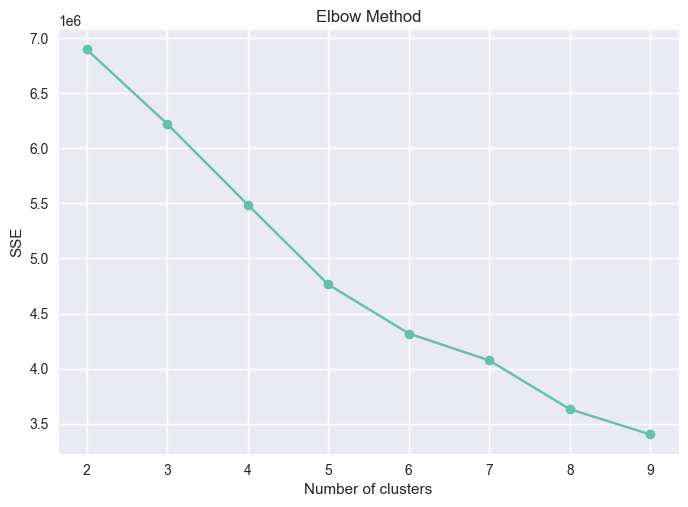

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

# Fit KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)


### Cluster Analysis

In [37]:
# Analyze clusters
cluster_summary = customer_df.groupby('Cluster')[features].mean()
cluster_summary.style.background_gradient(cmap='Blues')


,TotalTransactions,TotalSpent,AvgTransactionAmount,MaxTransactionAmount,CustAccountBalance_mean,CustomerAge_first,PreferredHour,CustGender_first,CustLocation_first,OwnedProductCount
Cluster,,,,,,,,,,
0,1.000000,1041.764250,1041.764250,1041.764250,71687.542362,37.922859,10.428860,2.000000,2983.313675,2.544274
1,1.002761,1251.893384,1249.753985,1251.011908,72548.901139,37.107444,10.386997,0.999659,2900.536624,2.871947
2,2.146008,2649.055657,1231.031114,2207.646189,91694.471363,37.863991,6.453054,1.723391,2970.370908,2.622703
3,1.179788,2579.259025,2256.446793,2481.086892,323638.171592,223.783710,10.004568,1.833078,2935.190411,3.601136
4,1.310641,71694.365210,60727.890267,71017.080515,420893.343675,85.368599,9.647961,1.748237,2922.501993,3.939896


### Visualization

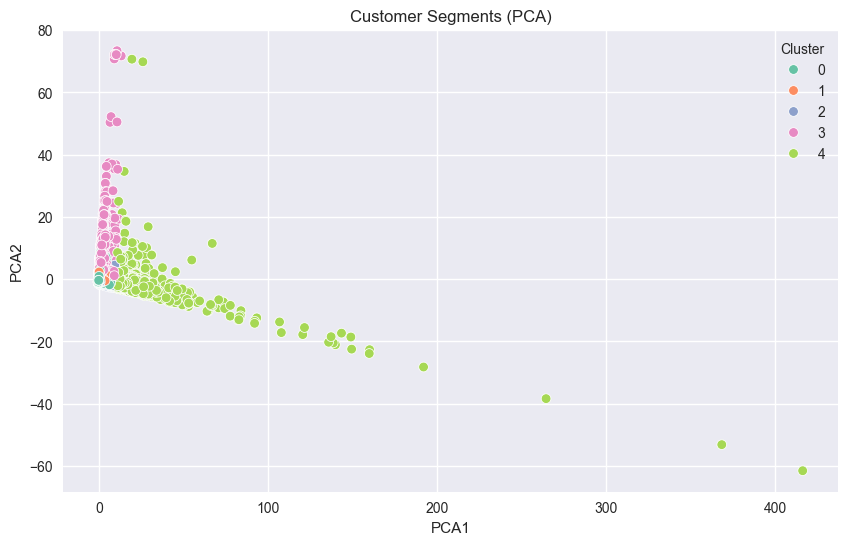

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PCA for visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)
customer_df['PCA1'] = pca_result[:, 0]
customer_df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_df, palette='Set2')
plt.title('Customer Segments (PCA)')
plt.show()


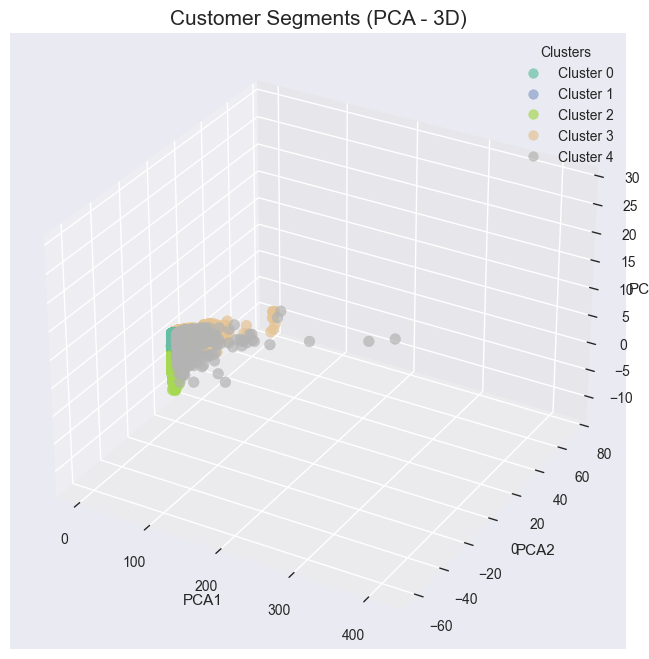

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Ensure 'PCA1', 'PCA2', 'PCA3' and 'Cluster' columns exist in customer_df
customer_df['PCA3'] = pca_result[:, 2]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
scatter = ax.scatter(
    customer_df['PCA1'],
    customer_df['PCA2'],
    customer_df['PCA3'],
    c=customer_df['Cluster'],  
    cmap='Set2',
    s=60,
    alpha=0.7
)

# Axis labels
ax.set_title('Customer Segments (PCA - 3D)', fontsize=15)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Optional: Add legend
handles, labels = scatter.legend_elements(prop="colors")
ax.legend(handles, [f'Cluster {i}' for i in range(len(set(customer_df["Cluster"])))], title="Clusters")

plt.show()


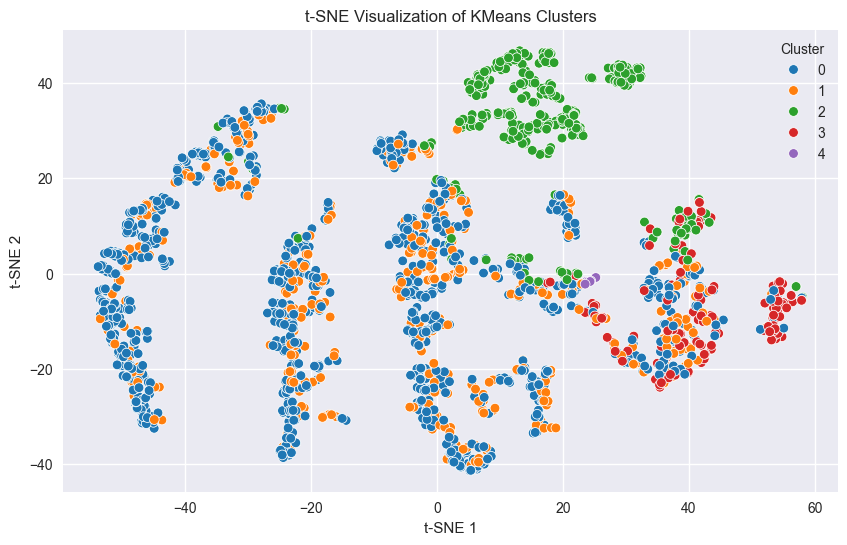

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


X_sampled = pca_result[:2000] 
cluster_sampled = customer_df['Cluster'][:2000]
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)

# Plot t-SNE results colored by KMeans clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_sampled, palette='tab10')
plt.title('t-SNE Visualization of KMeans Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### t-SNE 3D Plot of KMeans Clusters

In [45]:
# t-SNE for 3D visualization
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_sampled)

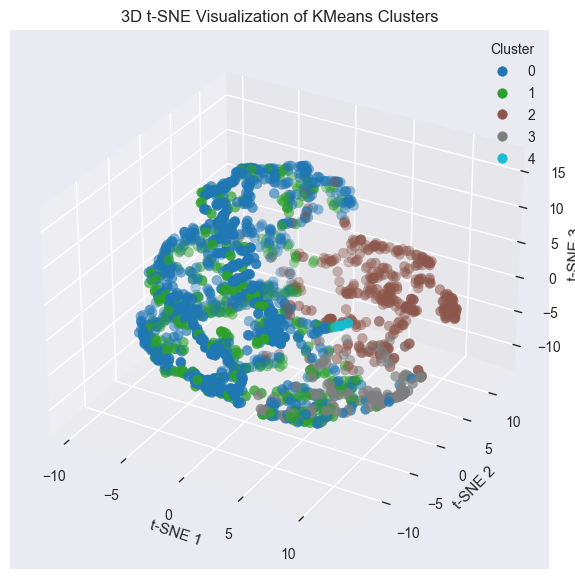

In [46]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                     c=cluster_sampled, cmap='tab10', s=50)

ax.set_title('3D t-SNE Visualization of KMeans Clusters')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


## GMM clustering 

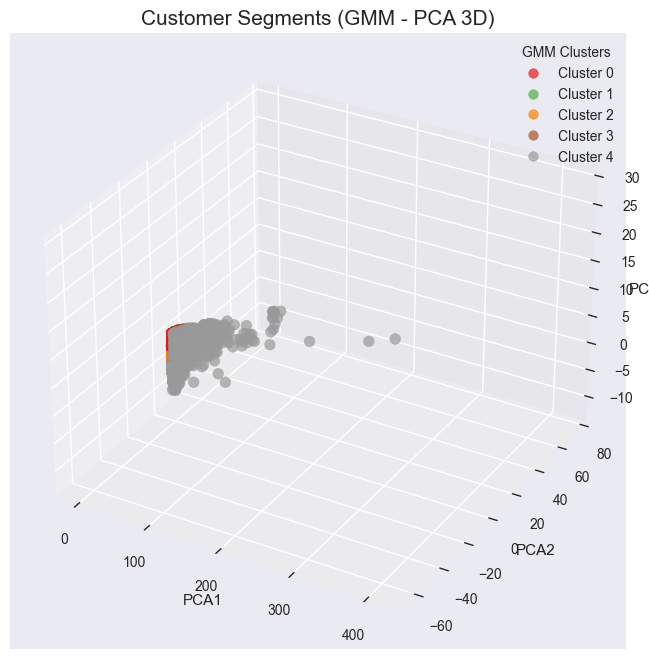

In [50]:
GMM = GaussianMixture(n_components=5, random_state=42)
GMM.fit(X_scaled)
customer_df['GMM_Cluster'] = GMM.predict(X_scaled)
# Add PCA3 if not already done
customer_df['PCA3'] = pca_result[:, 2]

# 3D PCA plot for GMM clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    customer_df['PCA1'],
    customer_df['PCA2'],
    customer_df['PCA3'],
    c=customer_df['GMM_Cluster'],
    cmap='Set1',
    s=60,
    alpha=0.7
)

ax.set_title('Customer Segments (GMM - PCA 3D)', fontsize=15)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

handles, labels = scatter.legend_elements(prop="colors")
ax.legend(handles, [f'Cluster {i}' for i in range(len(set(customer_df["GMM_Cluster"])))], title="GMM Clusters")

plt.show()


### t-SNE 2D

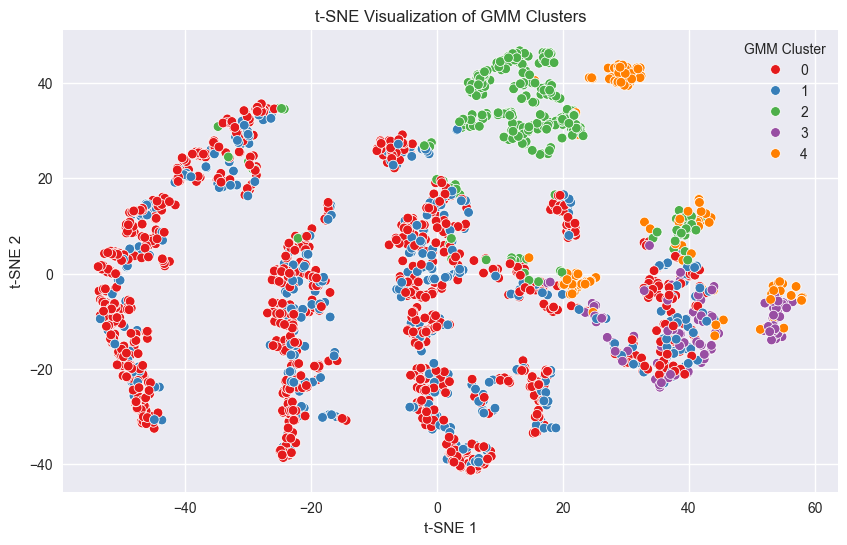

In [51]:
# Sample data for visualization
X_sampled = pca_result[:2000]
gmm_cluster_sampled = customer_df['GMM_Cluster'][:2000]

# t-SNE for 2D visualization (GMM)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=gmm_cluster_sampled, palette='Set1')
plt.title('t-SNE Visualization of GMM Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='GMM Cluster')
plt.grid(True)
plt.show()


### t-SNE 3D

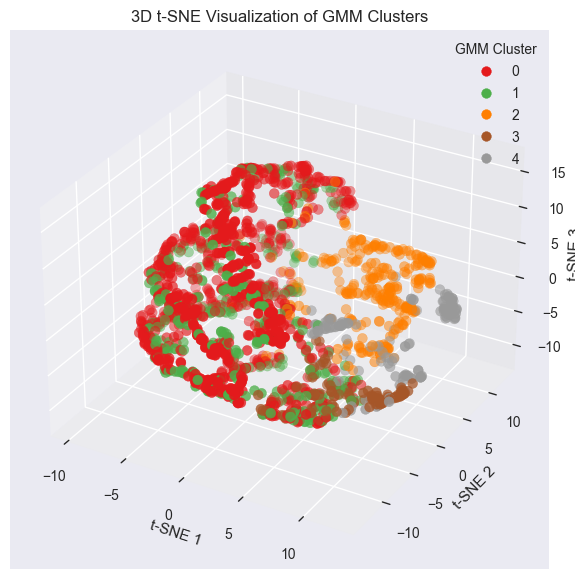

In [52]:
# t-SNE for 3D visualization
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_sampled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                     c=gmm_cluster_sampled, cmap='Set1', s=50)

ax.set_title('3D t-SNE Visualization of GMM Clusters')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.legend(*scatter.legend_elements(), title="GMM Cluster")
plt.show()


In [53]:
gmm_cluster_summary = customer_df.groupby('GMM_Cluster')[features].mean()
gmm_cluster_summary.style.background_gradient(cmap='Oranges')


,TotalTransactions,TotalSpent,AvgTransactionAmount,MaxTransactionAmount,CustAccountBalance_mean,CustomerAge_first,PreferredHour,CustGender_first,CustLocation_first,OwnedProductCount
GMM_Cluster,,,,,,,,,,
0,1.000000,857.833611,857.833611,857.833611,44538.050417,37.847846,10.427322,2.000000,2985.769910,2.489247
1,1.000000,1085.834680,1085.834680,1085.834680,57927.353028,37.051430,10.352074,1.000000,2901.458866,2.837670
2,2.000000,1922.463448,961.231724,1603.925427,59484.888398,37.621977,6.666384,1.719673,2969.118997,2.593987
3,1.000000,2232.674929,2232.674929,2232.674929,169356.768312,225.000000,10.654539,1.831805,2935.727637,3.551930
4,2.025423,11222.213922,8512.227789,10614.628395,662661.400018,76.024603,7.717369,1.770524,2934.360174,3.645999


## summary table

In [60]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import pandas as pd


# X_sampled = pca_result[:2000] 
# cluster_sampled = customer_df['Cluster'][:2000]
X = pca_result[:2000]  

results = []

for k in range(2, 11):
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_score = silhouette_score(X, kmeans_labels)

    results.append({
        'Model': 'KMeans',
        'k': k,
        'Silhouette Score': round(kmeans_score, 4),
        'AIC': None,
        'BIC': None
    })

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_score = silhouette_score(X, gmm_labels)
    gmm_aic = gmm.aic(X)
    gmm_bic = gmm.bic(X)

    results.append({
        'Model': 'GMM',
        'k': k,
        'Silhouette Score': round(gmm_score, 4),
        'AIC': round(gmm_aic, 2),
        'BIC': round(gmm_bic, 2)
    })


In [61]:
# display results 
trial_log_df = pd.DataFrame(results)
display(trial_log_df.sort_values(by=['Model', 'k']))

,Model,k,Silhouette Score,AIC,BIC
1,GMM,2,0.3969,13143.00,13249.41
3,GMM,3,0.2379,11712.98,11875.40
5,GMM,4,0.1957,11385.38,11603.82
7,GMM,5,-0.0025,10921.28,11195.72
9,GMM,6,0.0196,10896.23,11226.69
11,GMM,7,0.0146,10677.46,11063.93
13,GMM,8,0.0453,10810.94,11253.41
15,GMM,9,0.0013,10596.00,11094.48
17,GMM,10,0.0079,10577.00,11131.49
0,KMeans,2,0.8864,NaN,NaN


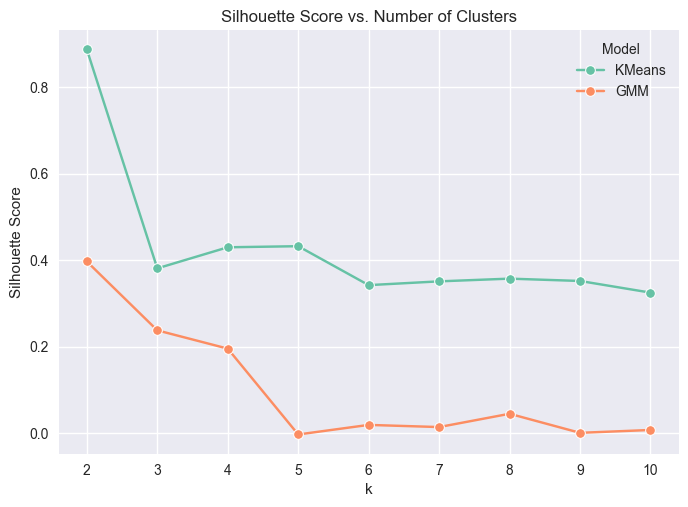

In [62]:
# plot silhouette scores
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=trial_log_df, x='k', y='Silhouette Score', hue='Model', marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()


## Silhouette Score Overview:
It measures how similar a point is to its own cluster compared to other clusters.

The score ranges from -1 to 1:

+1: Perfectly matched to its own cluster, and far from others.

0: On or very close to the decision boundary between clusters.

Negative: Possibly assigned to the wrong cluster.

## =============================================


## then we deduce that the K-means is better 

## ===========================================


## Bounus part Recommendation system 

In [63]:
customer_df.head()


,CustomerID,TotalTransactions,TotalSpent,AvgTransactionAmount,MaxTransactionAmount,PreferredHour,CustGender_first,CustLocation_first,CustAccountBalance_mean,CustomerAge_first,OwnedProducts_first,OwnedProductCount,Cluster,PCA1,PCA2,PCA3,CustLocation_standardized,GMM_Cluster
0,C1010011,2,5106.0,2553.0,4750.0,3,1,3610,76340.635,33.0,"""credit card, savings""",2,2,0.715034,-0.712633,-1.994414,5286,2
1,C1010012,1,1499.0,1499.0,1499.0,8,2,3148,24204.490,31.0,"""credit card, loans, savings""",3,0,-0.074030,-0.156491,0.115174,4730,0
2,C1010014,2,1455.0,727.5,1205.0,13,1,3148,100112.950,33.0,"""credit card, savings""",2,2,-0.095303,-0.446167,-0.945018,4730,2
3,C1010018,1,30.0,30.0,30.0,23,1,376,496.180,35.0,loans,1,1,-0.603173,-0.581493,1.739407,1388,1
5,C1010028,1,557.0,557.0,557.0,2,1,810,296828.370,37.0,"""cds, credit card, long term investment, retir...",6,1,-0.038978,1.650624,-0.789201,1880,1


In [64]:
# Step 1: Normalize and split product names
customer_df['OwnedProducts_first'] = customer_df['OwnedProducts_first'].str.lower().str.replace(' ', '')
customer_df['OwnedProducts_list'] = customer_df['OwnedProducts_first'].str.split(',')

# Step 2: Create binary ownership columns
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
owned_product_df = pd.DataFrame(
    mlb.fit_transform(customer_df['OwnedProducts_list']),
    columns=mlb.classes_,
    index=customer_df.index
)

# Step 3: Combine back with the main DataFrame
customer_df = pd.concat([customer_df, owned_product_df], axis=1)


In [65]:
product_cols = mlb.classes_.tolist()  # ['cds', 'creditcard', 'loans', 'longterminvestment', 'retirementplan', 'savings']

cluster_product_profile = customer_df.groupby('Cluster')[product_cols].mean()


In [66]:
def recommend_products(customer_id, threshold=0.5):
    try:
        customer_row = customer_df[customer_df['CustomerID'] == customer_id]
        if customer_row.empty:
            return f"Customer ID {customer_id} not found."

        cluster = customer_row['Cluster'].values[0]
        popular_products = cluster_product_profile.loc[cluster]

        recommendations = []
        for product in product_cols:
            if customer_row.iloc[0][product] == 0 and popular_products[product] >= threshold:
                recommendations.append(product)

        return recommendations if recommendations else ["No recommendation based on current threshold."]
    
    except Exception as e:
        return f"Error: {e}"


In [68]:
customer_df['Recommended_Products'] = customer_df['CustomerID'][:2000].apply(recommend_products)


In [69]:
print("Recommendations for C1010018:")
print(recommend_products("C1010018"))


Recommendations for C1010018:
['savings"']
